### Import Libraries & Prep

In [1]:
import requests
import sagemaker
import boto3
import s3fs
import json
import io

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.serializers import NumpySerializer
from sagemaker.deserializers import NumpyDeserializer
from sagemaker.local import LocalSession

from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
%matplotlib inline
sns.set()

seed = 42
rand = np.random.RandomState(seed)

local_mode = False # activate to use local mode

In [3]:
with open("config.json") as f:
    configs = json.load(f)

In [4]:
default_bucket = configs["default_bucket"] #put your bucket name here
role = configs["role_arn"] # put your sagemaker role arn here

boto_session = boto3.Session()
   
if local_mode:
    sagemaker_session = LocalSession(boto_session = boto_session)
    sagemaker_session._default_bucket = default_bucket
else:
    sagemaker_session = sagemaker.Session(
        boto_session = boto_session,
        default_bucket = default_bucket
    )

ecr_image = configs["image_arn"] #put the image uri from ECR here

prefix = "modeling/sagemaker"

data_name = f"gauss3"
test_name = "gam-demo"

In [5]:
def get_s3fs():
    return s3fs.S3FileSystem(key = boto_session.get_credentials().access_key,
                             secret = boto_session.get_credentials().secret_key,
                             token = boto_session.get_credentials().token)

def plot_and_clear():
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

### Read, Visualize, & Prep Data

In [6]:
url = "https://www.itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Gauss3.dat"

r = requests.get(url)

In [7]:
for i,t in enumerate(r.text.splitlines()):
    print(f"{i:03d}\t{t}")

000	NIST/ITL StRD
001	Dataset Name:  Gauss3            (Gauss3.dat)
002	
003	File Format:   ASCII
004	               Starting Values   (lines 41 to  48)
005	               Certified Values  (lines 41 to  53)
006	               Data              (lines 61 to 310)
007	
008	Procedure:     Nonlinear Least Squares Regression
009	
010	Description:   The data are two strongly-blended Gaussians on a 
011	               decaying exponential baseline plus normally 
012	               distributed zero-mean noise with variance = 6.25.
013	
014	Reference:     Rust, B., NIST (1996).
015	
016	
017	
018	
019	
020	
021	
022	
023	
024	Data:          1 Response  (y)
025	               1 Predictor (x)
026	               250 Observations
027	               Average Level of Difficulty
028	               Generated Data
029	
030	Model:         Exponential Class
031	               8 Parameters (b1 to b8)
032	
033	               y = b1*exp( -b2*x ) + b3*exp( -(x-b4)**2 / b5**2 )
034	                            

In [8]:
y, x = np.loadtxt(io.StringIO(r.text[r.text.index("Data:   y          x"):]), skiprows=1, unpack=True)
x = x.reshape(-1, 1)

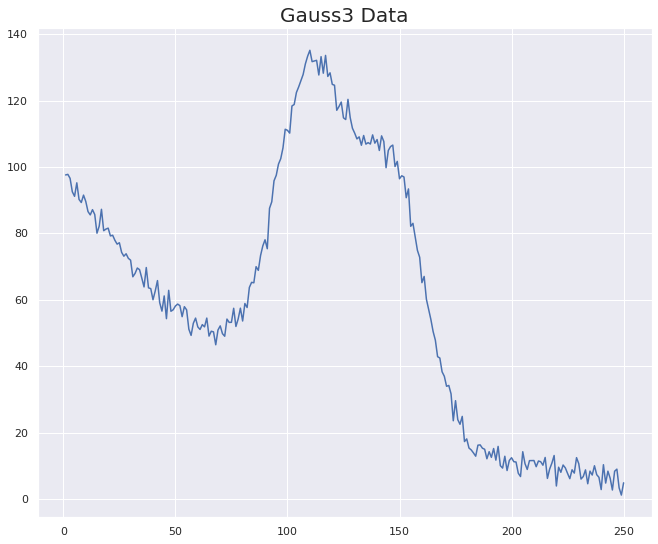

In [9]:
fig, ax = plt.subplots(figsize = (11,9))
ax.plot(x,y)
ax.set_title("Gauss3 Data", size = 20)
plot_and_clear()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = rand)

In [11]:
# remove entires in X_test outside the extremes of X_train

ind = np.all(
    (X_test >= X_train.min(axis = 0, keepdims = True)) &
    (X_test <= X_train.max(axis = 0, keepdims = True)), 
    axis = 1)

X_test = X_test[ind]
y_test = y_test[ind]

In [12]:
file_fn = f"{default_bucket}/{prefix}/{data_name}/train/data.csv"
file_path = f"s3://{file_fn}"

s3 = get_s3fs()
with s3.open(file_fn, 'wb') as f:
    np.savetxt(f, np.c_[X_train, y_train], delimiter = ',')

In [13]:
hyperparameters = {
    "train-file": "data.csv",
    "df": "20"
}

data_channels = {
    "train": file_path
}

In [14]:
estimator = Estimator(
    role = role,
    sagemaker_session = sagemaker_session,
    instance_count = 1,
    instance_type = "local" if local_mode else "ml.m5.large",
    image_uri = ecr_image,
    base_job_name = f'{data_name}-{test_name}',
    hyperparameters = hyperparameters,
    output_path = f"s3://{default_bucket}/{prefix}/{data_name}/model"
)                      

In [15]:
estimator.fit(data_channels, wait = True, logs = "None")
job_name = estimator.latest_training_job.name
print(job_name)


2020-12-21 17:34:11 Starting - Starting the training job
2020-12-21 17:34:13 Starting - Launching requested ML instances..............
2020-12-21 17:35:31 Starting - Preparing the instances for training........
2020-12-21 17:36:15 Downloading - Downloading input data..
2020-12-21 17:36:31 Training - Downloading the training image..............
2020-12-21 17:37:49 Training - Training image download completed. Training in progress..
2020-12-21 17:37:57 Uploading - Uploading generated training model
2020-12-21 17:38:02 Completed - Training job completed
gauss3-gam-demo-2020-12-21-17-34-10-929


In [16]:
np_serialize = NumpySerializer()
np_deserialize = NumpyDeserializer()

predictor = estimator.deploy(
    initial_instance_count = 1,
    instance_type = "local" if local_mode else "ml.t2.medium",
    serializer = np_serialize,
    deserializer = np_deserialize
)

-----------------!

In [17]:
y_hat_train = predictor.predict(X_train)
y_hat_test = predictor.predict(X_test)

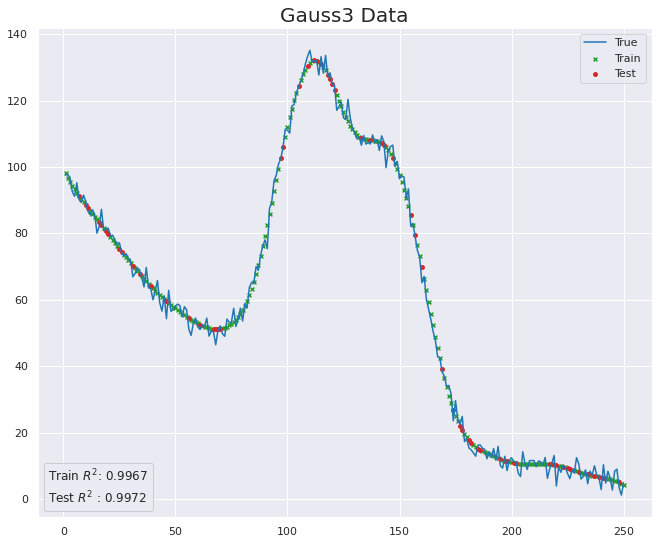

In [18]:
fig, ax = plt.subplots(figsize = (11,9))
ax.plot(x, y, color = "tab:blue", label = "True")
ax.scatter(X_train, y_hat_train, 
           color = "tab:green", s = 15, 
           marker = "x", label = "Train")
ax.scatter(X_test, y_hat_test, 
           color = "tab:red", s = 15, 
           marker = "o", label = "Test")
leg1 = ax.legend(loc = "upper right")

labels = [
    "{:11s}: {:.4f}".format(r"Train $R^2$", 
                            r2_score(y_train, y_hat_train)),
    "{:11s}: {:.4f}".format(r"Test $R^2$", 
                            r2_score(y_test, y_hat_test))
]

handles = [
    mpl.patches.Rectangle((0, 0), 1, 1, 
                         lw = 0, alpha = 0)
]
handles *= len(labels)

leg2 = ax.legend(
    handles, labels, loc='lower left', fontsize = 12, 
    fancybox=True, framealpha=1.0, 
    handlelength=0, handletextpad=0, ncol=1,
)
ax.add_artist(leg1)

ax.set_title("Gauss3 Data", size = 20)
plot_and_clear()

In [19]:
predictor.delete_endpoint()
predictor.delete_model()